# Regressions

In [2]:
# connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [26]:
# importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import shapiro, probplot
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats


sns.set(style="whitegrid")

In [4]:
# ---- Loading in the data -----
df_train = pd.read_excel('/content/drive/MyDrive/Masters Thesis/Colab notebook/combined_training_data_add.xlsx')
df_val = pd.read_excel('/content/drive/MyDrive/Masters Thesis/Colab notebook/combined_validation_data_add.xlsx')
df_test = pd.read_excel('/content/drive/MyDrive/Masters Thesis/Colab notebook/combined_test_data_add.xlsx')


In [5]:
# ---- Checking missing values ----
missing_values = df_train.isna().sum()
missing_values

,0
trading_day,0
IWSS_Equal,0
IWSS_Ratio,0
IWSS_Impurity,0
IWSS_perm,0
IWSS_SHAP,0
IWSS_metric,0
IWSS_PCA,0
Sentiment_score,0
Date,0


In [6]:
df_train = df_train.dropna(subset=['return_t'])
df_train['trading_day'] = pd.to_datetime(df_train['trading_day'])

<ipython-input-6-fe7202b4425a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['trading_day'] = pd.to_datetime(df_train['trading_day'])


## Defining features

In [7]:
base_features = ['return_t', 'Volume', 'VIX']
sentiment_features = ['IWSS_Equal', 'IWSS_Ratio', 'IWSS_Impurity', 'IWSS_perm',
                      'IWSS_SHAP', 'IWSS_metric', 'IWSS_PCA', 'Sentiment_score']
all_features = base_features + sentiment_features
target = 'return_t+1'

## RIDGE Assumptions

In [8]:
def check_ridge_assumptions(X_scaled, y_true, y_pred, residuals, feature_names, label=None):
    model_name = f"Ridge Model: {label}" if label else "Ridge Model"
    print(f"\n{'='*60}\nChecking Assumptions — {model_name}\n{'='*60}")

    conclusions = {}

    # Linearity Check
    print("\n[1] Linearity (Residuals vs. Predicted)")
    plt.figure(figsize=(6, 4))
    plt.scatter(y_pred, residuals, alpha=0.7)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.title(f"{model_name} — Residuals vs. Predicted")
    plt.tight_layout()
    plt.show()
    conclusions['Linearity'] = "Check visually for random scatter in residuals."

    # Multicollinearity — VIF
    print("\n[2] Multicollinearity (VIF)")
    X_df = pd.DataFrame(X_scaled, columns=feature_names)
    vif_data = pd.DataFrame()
    vif_data["Feature"] = feature_names
    vif_data["VIF"] = [variance_inflation_factor(X_df.values, i) for i in range(X_df.shape[1])]
    print(vif_data)

    high_vif = vif_data[vif_data["VIF"] > 3]
    if not high_vif.empty:
        conclusions['Multicollinearity'] = f"⚠️ High VIF: {len(high_vif)} feature(s) > 3"
    else:
        conclusions['Multicollinearity'] = "✅ VIF values are acceptable (≤ 3)"

    # Autocorrelation — Durbin-Watson
    print("\n[3] Autocorrelation (Durbin-Watson)")
    dw_stat = durbin_watson(residuals)
    print(f"Durbin-Watson Statistic: {dw_stat:.3f} (ideal ≈ 2)")
    if dw_stat < 1.5 or dw_stat > 2.5:
        conclusions['Autocorrelation'] = f"⚠️ DW = {dw_stat:.3f} (potential autocorrelation)"
    else:
        conclusions['Autocorrelation'] = f"✅ DW = {dw_stat:.3f} (no serious autocorrelation)"

    # Normality of Residuals
    print("\n[4] Normality of Residuals")
    plt.figure(figsize=(6, 4))
    sns.histplot(residuals, kde=True)
    plt.title(f"{model_name} — Histogram of Residuals")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 4))
    probplot(residuals, dist="norm", plot=plt)
    plt.title(f"{model_name} — Q-Q Plot")
    plt.tight_layout()
    plt.show()

    shapiro_stat, shapiro_p = shapiro(residuals)
    print(f"Shapiro-Wilk Test p-value: {shapiro_p:.4f} (p > 0.05 suggests normality)")
    conclusions['Normality'] = (
        f"{'✅' if shapiro_p > 0.05 else '⚠️ Problem:'} "
        f"p-value = {shapiro_p:.4f} ({'normal' if shapiro_p > 0.05 else 'non-normal'} residuals)"
    )

    # Summary
    print(f"\n{'-'*50}\nConclusion Summary — {model_name}\n{'-'*50}")
    for k, v in conclusions.items():
        print(f"{k}: {v}")


## Ridge regression

In [86]:
def evaluate_ridge_model_extended(name, X_train, y_train, X_val, y_val, X_test, y_test, alphas):
    feature_names = X_val.columns.tolist()

    # Standardize
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # Train Ridge with CV
    ridge = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error', cv=5)
    ridge.fit(X_train_scaled, y_train)
    alpha = ridge.alpha_

    # Predictions
    y_train_pred = ridge.predict(X_train_scaled)
    y_val_pred = ridge.predict(X_val_scaled)
    y_test_pred = ridge.predict(X_test_scaled)

    # Errors
    test_errors = y_test - y_test_pred

    # --- Metrics ---
    def metrics(y_true, y_pred, ref_mean=None):
        mse = mean_squared_error(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_true, y_pred)
        correct = (np.sign(y_true) == np.sign(y_pred)).sum()
        accuracy = correct / len(y_true)
        roos = None
        if ref_mean is not None:
            roos = 1 - np.sum((y_true - y_pred) ** 2) / np.sum((y_true - ref_mean) ** 2)
        return mse, mae, rmse, r2, accuracy, correct, roos

    train_mean = np.mean(y_train)

    train_mse, train_mae, train_rmse, train_r2, train_acc, train_correct, train_roos = metrics(y_train, y_train_pred, train_mean)
    val_mse, val_mae, val_rmse, val_r2, val_acc, val_correct, _ = metrics(y_val, y_val_pred)
    test_mse, test_mae, test_rmse, test_r2, test_acc, test_correct, test_roos = metrics(y_test, y_test_pred, train_mean)

    results_ridge.append({
        'Model': name,
        'Best Alpha': alpha,
        'Train R²': train_r2,
        'Train MSE': train_mse,
        'Train MAE': train_mae,
        'Train RMSE': train_rmse,
        'Train ROOS': train_roos,
        'Train Directional Accuracy (%)': train_acc * 100,
        'Train Correct': train_correct,
        'Train Total': len(y_train),
        'Val R²': val_r2,
        'Val MSE': val_mse,
        'Val MAE': val_mae,
        'Val RMSE': val_rmse,
        'Val Directional Accuracy (%)': val_acc * 100,
        'Val Correct': val_correct,
        'Val Total': len(y_val),
        'Test R²': test_r2,
        'Test MSE': test_mse,
        'Test MAE': test_mae,
        'Test RMSE': test_rmse,
        'Test ROOS': test_roos,
        'Test Directional Accuracy (%)': test_acc * 100,
        'Test Correct': test_correct,
        'Test Total': len(y_test)
    })

    return model, scaler, test_errors


In [20]:
df_test = df_test.dropna(subset=['return_t+1'])

In [106]:
results_ridge = []
errors_dict_ridge = {}
models_ridge = {}
scalers_ridge = {}
alphas = np.logspace(0, 4, 20)
features_used_per_model = {}

# Extract target
y_train = df_train[target]
y_val = df_val[target]
y_test = df_test[target]

# Base
model_name = 'Base'
feature_set = base_features

print(f"✅ Training {model_name} with: {feature_set}")

model, scaler, test_errors = evaluate_ridge_model_extended(
    name='Base',
    X_train=df_train[base_features],
    y_train=y_train,
    X_val=df_val[base_features],
    y_val=y_val,
    X_test=df_test[base_features],
    y_test=y_test,
    alphas=alphas
)
models_ridge['Base'] = model
scalers_ridge['Base'] = scaler
errors_dict_ridge['Base'] = test_errors
features_used_per_model[model_name] = feature_set

# Sentiment
model_name = 'Sentiment_score'
feature_set = base_features + ['Sentiment_score']
print(f"✅ Training {model_name} with: {feature_set}")

model, scaler, test_errors = evaluate_ridge_model_extended(
    name='Base + Sentiment_score',
    X_train=df_train[base_features + ['Sentiment_score']],
    y_train=y_train,
    X_val=df_val[base_features + ['Sentiment_score']],
    y_val=y_val,
    X_test=df_test[base_features + ['Sentiment_score']],
    y_test=y_test,
    alphas=alphas
)
models_ridge['Sentiment_score'] = model
scalers_ridge['Sentiment_score'] = scaler
errors_dict_ridge['Sentiment_score'] = test_errors
features_used_per_model[model_name] = feature_set
sentiment_errors = test_errors

# IWSS
for feat in sentiment_features:
    if feat == 'Sentiment_score':
        continue

    model_name = f'Base + {feat}'
    feature_set = base_features + [feat]

    print(f"✅ Training {model_name} with: {feature_set}")

    model, scaler, test_errors = evaluate_ridge_model_extended(
        name=model_name,
        X_train=df_train[feature_set],
        y_train=y_train,
        X_val=df_val[feature_set],
        y_val=y_val,
        X_test=df_test[feature_set],
        y_test=y_test,
        alphas=alphas
    )
    models_ridge[model_name] = model
    scalers_ridge[model_name] = scaler
    errors_dict_ridge[model_name] = test_errors
    features_used_per_model[model_name] = feature_set


✅ Training Base with: ['return_t', 'Volume', 'VIX']
✅ Training Sentiment_score with: ['return_t', 'Volume', 'VIX', 'Sentiment_score']
✅ Training Base + IWSS_Equal with: ['return_t', 'Volume', 'VIX', 'IWSS_Equal']
✅ Training Base + IWSS_Ratio with: ['return_t', 'Volume', 'VIX', 'IWSS_Ratio']
✅ Training Base + IWSS_Impurity with: ['return_t', 'Volume', 'VIX', 'IWSS_Impurity']
✅ Training Base + IWSS_perm with: ['return_t', 'Volume', 'VIX', 'IWSS_perm']
✅ Training Base + IWSS_SHAP with: ['return_t', 'Volume', 'VIX', 'IWSS_SHAP']
✅ Training Base + IWSS_metric with: ['return_t', 'Volume', 'VIX', 'IWSS_metric']
✅ Training Base + IWSS_PCA with: ['return_t', 'Volume', 'VIX', 'IWSS_PCA']


In [107]:
results_ridge = pd.DataFrame(results_ridge)
results_ridge

,Model,Best Alpha,Train R²,Train MSE,Train MAE,Train RMSE,Train ROOS,Train Directional Accuracy (%),Train Correct,Train Total,...,Val Correct,Val Total,Test R²,Test MSE,Test MAE,Test RMSE,Test ROOS,Test Directional Accuracy (%),Test Correct,Test Total
0,Base,2335.721469,0.001715,0.000159,0.009601,0.012615,0.001715,52.941176,243,459,...,61,147,-0.016049,0.000074,0.006234,0.008574,-0.003204,44.897959,66,147
1,Base + Sentiment_score,545.559478,0.011521,0.000158,0.009583,0.012553,0.011521,51.851852,238,459,...,61,147,-0.053274,0.000076,0.006498,0.008730,-0.039958,44.897959,66,147
2,Base + IWSS_Equal,6158.482111,0.000874,0.000159,0.009598,0.012620,0.000874,52.941176,243,459,...,59,147,-0.013357,0.000073,0.006213,0.008563,-0.000546,42.176871,62,147
3,Base + IWSS_Ratio,6158.482111,0.000847,0.000159,0.009598,0.012620,0.000847,53.159041,244,459,...,59,147,-0.013491,0.000073,0.006213,0.008563,-0.000678,42.176871,62,147
4,Base + IWSS_Impurity,6158.482111,0.000857,0.000159,0.009598,0.012620,0.000857,52.941176,243,459,...,59,147,-0.013448,0.000073,0.006213,0.008563,-0.000636,42.176871,62,147
5,Base + IWSS_perm,6158.482111,0.000865,0.000159,0.009598,0.012620,0.000865,52.941176,243,459,...,59,147,-0.013404,0.000073,0.006213,0.008563,-0.000593,42.176871,62,147
6,Base + IWSS_SHAP,6158.482111,0.000868,0.000159,0.009598,0.012620,0.000868,52.941176,243,459,...,59,147,-0.013372,0.000073,0.006213,0.008563,-0.000561,42.176871,62,147
7,Base + IWSS_metric,885.866790,0.005316,0.000159,0.009592,0.012592,0.005316,53.159041,244,459,...,61,147,-0.030776,0.000075,0.006335,0.008636,-0.017745,44.897959,66,147
8,Base + IWSS_PCA,3792.690191,0.001282,0.000159,0.009599,0.012618,0.001282,53.159041,244,459,...,61,147,-0.014314,0.000073,0.006221,0.008567,-0.001490,43.537415,64,147


## Diebold Mariano Test

### Based on MSE

In [76]:
def diebold_mariano_test(e1, e2, crit='MSE'):
    e1, e2 = np.asarray(e1), np.asarray(e2)
    if crit == 'MSE':
        d = (e1 ** 2) - (e2 ** 2)
    elif crit == 'MAE':
        d = np.abs(e1) - np.abs(e2)
    else:
        raise ValueError("crit must be 'MSE' or 'MAE'")
    mean_d = np.mean(d)
    std_d = np.std(d, ddof=1)
    n = len(d)
    dm_stat = mean_d / (std_d / np.sqrt(n))
    p_value = 2 * (1 - stats.t.cdf(np.abs(dm_stat), df=n - 1))
    return dm_stat, p_value

In [77]:
dm_results = []
for model_name, errors in errors_dict_ridge.items():
    if model_name in ['Sentiment_score', 'Base']:
        continue
    dm_stat, p_value = diebold_mariano_test(errors, sentiment_errors, crit='MSE')
    dm_results.append({
        'Model Compared': f'Base + {model_name}',
        'DM Statistic': dm_stat,
        'p-value': p_value,
        'Interpretation': 'Sentiment better' if dm_stat > 0 else 'IWSS better'
    })

In [78]:
dm_df_ridge = pd.DataFrame(dm_results).sort_values(by='p-value')
results_df_ridge = pd.DataFrame(results_ridge)

dm_df_ridge

,Model Compared,DM Statistic,p-value,Interpretation
6,Base + Base + IWSS_PCA,-2.248268,0.026057,IWSS better
0,Base + Base + IWSS_Equal,-2.218132,0.028090,IWSS better
4,Base + Base + IWSS_SHAP,-2.217224,0.028154,IWSS better
3,Base + Base + IWSS_perm,-2.216342,0.028215,IWSS better
2,Base + Base + IWSS_Impurity,-2.214763,0.028326,IWSS better
1,Base + Base + IWSS_Ratio,-2.212871,0.028459,IWSS better
5,Base + Base + IWSS_metric,-1.570299,0.118510,IWSS better


### Based on MAE

In [79]:
def diebold_mariano_test(e1, e2, crit='MAE'):
    e1, e2 = np.asarray(e1), np.asarray(e2)
    if crit == 'MSE':
        d = (e1 ** 2) - (e2 ** 2)
    elif crit == 'MAE':
        d = np.abs(e1) - np.abs(e2)
    else:
        raise ValueError("crit must be 'MSE' or 'MAE'")
    mean_d = np.mean(d)
    std_d = np.std(d, ddof=1)
    n = len(d)
    dm_stat = mean_d / (std_d / np.sqrt(n))
    p_value = 2 * (1 - stats.t.cdf(np.abs(dm_stat), df=n - 1))
    return dm_stat, p_value

In [80]:
dm_results_mae = []
sentiment_errors = errors_dict_ridge['Sentiment_score']

for model_name, errors in errors_dict_ridge.items():
    if model_name in ['Sentiment_score', 'Base']:
        continue  # Skip baseline comparisons

    dm_stat, p_value = diebold_mariano_test(errors, sentiment_errors, crit='MAE')

    dm_results_mae.append({
        'Model Compared': f'Base + {model_name}',
        'DM Statistic (MAE)': dm_stat,
        'p-value (MAE)': p_value,
        'Interpretation': 'Sentiment better' if dm_stat > 0 else 'IWSS better'
    })

dm_df_mae = pd.DataFrame(dm_results_mae).sort_values(by='p-value (MAE)')
dm_df_mae

,Model Compared,DM Statistic (MAE),p-value (MAE),Interpretation
6,Base + Base + IWSS_PCA,-3.467202,0.000691,IWSS better
0,Base + Base + IWSS_Equal,-3.425596,0.000797,IWSS better
4,Base + Base + IWSS_SHAP,-3.424043,0.000801,IWSS better
3,Base + Base + IWSS_perm,-3.423499,0.000803,IWSS better
2,Base + Base + IWSS_Impurity,-3.421767,0.000807,IWSS better
1,Base + Base + IWSS_Ratio,-3.419119,0.000815,IWSS better
5,Base + Base + IWSS_metric,-2.521938,0.012744,IWSS better


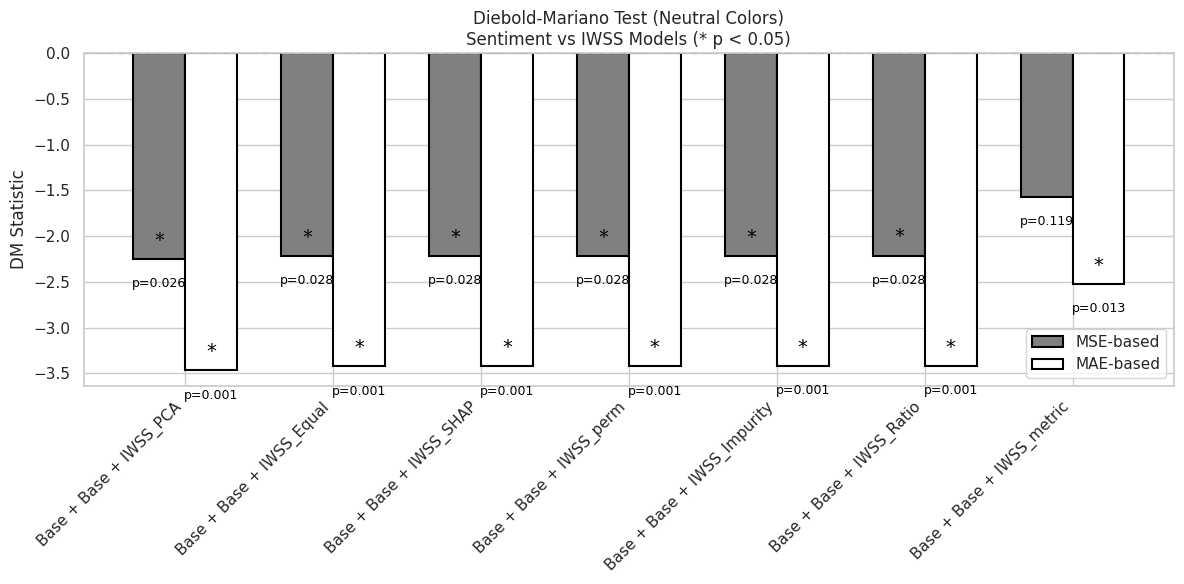

In [81]:
dm_combined = pd.merge(
    dm_df_ridge[['Model Compared', 'DM Statistic', 'p-value']],
    dm_df_mae[['Model Compared', 'DM Statistic (MAE)', 'p-value (MAE)']],
    on='Model Compared'
)

dm_combined_sorted = dm_combined.sort_values(by='DM Statistic')
x = np.arange(len(dm_combined_sorted))
bar_width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))

bars1 = ax.bar(
    x,
    dm_combined_sorted['DM Statistic'],
    width=bar_width,
    label='MSE-based',
    color='gray',
    edgecolor='black',
    linewidth=1.5
)
bars2 = ax.bar(
    x + bar_width,
    dm_combined_sorted['DM Statistic (MAE)'],
    width=bar_width,
    label='MAE-based',
    color='white',
    edgecolor='black',
    linewidth=1.5
)

# Add significance stars and p-values (MSE)
for i, (p, stat) in enumerate(zip(dm_combined_sorted['p-value'], dm_combined_sorted['DM Statistic'])):
    if p < 0.05:
        ax.text(x[i], stat + 0.1, '*', ha='center', va='bottom', fontsize=14, color='black')
    ax.text(x[i], stat - 0.2, f'p={p:.3f}', ha='center', va='top', fontsize=9, color='black')

# Add significance stars and p-values (MAE)
for i, (p, stat) in enumerate(zip(dm_combined_sorted['p-value (MAE)'], dm_combined_sorted['DM Statistic (MAE)'])):
    if p < 0.05:
        ax.text(x[i] + bar_width, stat + 0.1, '*', ha='center', va='bottom', fontsize=14, color='black')
    ax.text(x[i] + bar_width, stat - 0.2, f'p={p:.3f}', ha='center', va='top', fontsize=9, color='black')

ax.axhline(0, color='gray', linestyle='--')
ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(dm_combined_sorted['Model Compared'], rotation=45, ha='right')
ax.set_ylabel('DM Statistic')
ax.set_title('Diebold-Mariano Test (Neutral Colors)\nSentiment vs IWSS Models (* p < 0.05)')
ax.legend()
plt.tight_layout()
plt.show()

In [108]:
coef_table = {}

for name, model in models_ridge.items():
    features = features_used_per_model.get(name)

    if features is None:
        print(f"❌ No feature record for {name}, skipping.")
        continue

    if len(model.coef_) == len(features):
        coef_table[name] = pd.Series(model.coef_, index=features)
    else:
        print(f"⚠️ Skipping {name}: {len(model.coef_)} coefficients vs {len(features)} features")

coef_df = pd.DataFrame(coef_table).T.fillna(0)
coef_df

⚠️ Skipping Base: 4 coefficients vs 3 features


,IWSS_Equal,IWSS_Impurity,IWSS_PCA,IWSS_Ratio,IWSS_SHAP,IWSS_metric,IWSS_perm,Sentiment_score,VIX,Volume,return_t
Sentiment_score,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000028,0.000063,0.000079,0.00002
Base + IWSS_Equal,-0.000028,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000063,0.000079,0.00002
Base + IWSS_Ratio,0.000000,0.000000,0.000000,-0.000028,0.000000,0.000000,0.000000,0.000000,0.000063,0.000079,0.00002
Base + IWSS_Impurity,0.000000,-0.000028,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000063,0.000079,0.00002
Base + IWSS_perm,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000028,0.000000,0.000063,0.000079,0.00002
Base + IWSS_SHAP,0.000000,0.000000,0.000000,0.000000,-0.000028,0.000000,0.000000,0.000000,0.000063,0.000079,0.00002
Base + IWSS_metric,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000028,0.000000,0.000000,0.000063,0.000079,0.00002
Base + IWSS_PCA,0.000000,0.000000,-0.000028,0.000000,0.000000,0.000000,0.000000,0.000000,0.000063,0.000079,0.00002


In [73]:
for name, model in models_ridge.items():
    print(name, model.coef_)

Base [ 1.96981136e-05  7.88421066e-05  6.27302040e-05 -2.79880256e-05]
Sentiment_score [ 1.96981136e-05  7.88421066e-05  6.27302040e-05 -2.79880256e-05]
IWSS_Equal [ 1.96981136e-05  7.88421066e-05  6.27302040e-05 -2.79880256e-05]
IWSS_Ratio [ 1.96981136e-05  7.88421066e-05  6.27302040e-05 -2.79880256e-05]
IWSS_Impurity [ 1.96981136e-05  7.88421066e-05  6.27302040e-05 -2.79880256e-05]
IWSS_perm [ 1.96981136e-05  7.88421066e-05  6.27302040e-05 -2.79880256e-05]
IWSS_SHAP [ 1.96981136e-05  7.88421066e-05  6.27302040e-05 -2.79880256e-05]
IWSS_metric [ 1.96981136e-05  7.88421066e-05  6.27302040e-05 -2.79880256e-05]
IWSS_PCA [ 1.96981136e-05  7.88421066e-05  6.27302040e-05 -2.79880256e-05]


In [67]:
print(models_ridge.keys())


dict_keys(['Base', 'Sentiment_score', 'IWSS_Equal', 'IWSS_Ratio', 'IWSS_Impurity', 'IWSS_perm', 'IWSS_SHAP', 'IWSS_metric', 'IWSS_PCA'])


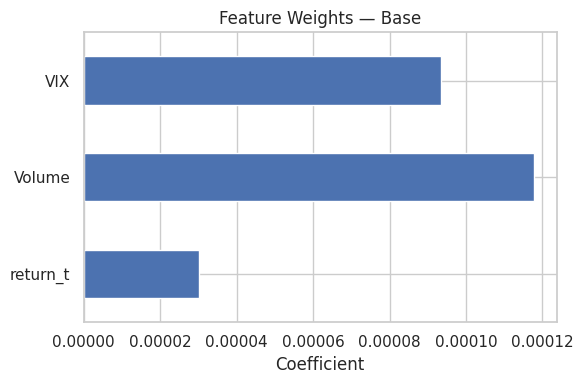

In [50]:
for model in coef_df.index:
    plt.figure(figsize=(6, 4))
    coef_df.loc[model].dropna().plot(kind='barh')
    plt.title(f"Feature Weights — {model}")
    plt.xlabel("Coefficient")
    plt.tight_layout()
    plt.show()
